# BASIC NLP: 2. 문자 단위 RNN으로 이름 생성하기

이번 튜토리얼에선 언어로 이름을 생성해본다.
이름을 읽고 그 언어를 예측하는것과 차이점은 언어를 입력하고 한번에 한글자를 생성하여 출력하는 것이다. 이처럼 문자를 반복적으로 예측하는것을 language model이라고 한다.

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## 데이터 준비

In [7]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os 
import unicodedata
import string

all_letters = string.ascii_letters + ".,;'-" 
n_letters = len(all_letters) + 1 

def findFiles(path): return glob.glob(path)

# 유니코드 문자열을 ASCII로 변환, https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# 파일을 읽고 줄 단위로 분리 
def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]
    
# 각 언어의 이름 목록인 category_lines 사전생성 
category_lines = {}
all_categories = []
for filename in findFiles('drive/MyDrive/Colab Notebooks/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines



    
n_categories = len(all_categories)
    
if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))
    

# categories: 18 ['Polish', 'Russian', 'Dutch', 'Czech', 'Spanish', 'Scottish', 'Greek', 'Arabic', 'Portuguese', 'French', 'Italian', 'Irish', 'German', 'Japanese', 'Korean', 'English', 'Chinese', 'Vietnamese']
O'Neal


## 네트워크 생성

이 네트워크는 다른 입력들과 연결되는 category tensor를 추가 인자로 가지게 확장한다. 이는 one-hot 벡터이다.
기존 입력과 category를 결합하여 입력으로 사용하기 떄문에 입력의 사이즈가 n_categories만큼 커진다.

출력은 다음 문자의 확률로 해석한다. 샘플링 단계에선 가장 확률이 높은 문자가 다음 입력 문자로 사용된다.

더 잘 실행이 되게끔 은닉과 출력을 결합하여 두번째 선형레이어인 o2o를 추가한다. 그리고 주어진 확률로 무작위로 입력의 일부분을 0으로 만드는 Drop-out 레이어가 있다. 이는 과적합을 방지하고 샘플링의 다양성을 높인다.

![image.png](attachment:653ae4bc-c3e4-4f3e-8bd8-556907b31588.png)

In [15]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self). __init__()
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden),1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output),1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
        

## 학습 준비

### 학습 준비 
(category, line)의 무작위 쌍을 얻는 함수 

In [35]:
import random

# 목록에서 무작위 아이템 반환 
def randomChoice(l):
    return l[random.randint(0, len(l) -1)]

# 임의의 category 및 그 category에서 무작위 이름 얻기
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

각 타임스텝마다 네트워크 입력은 (category, current letter, hidden state)가 되고 출력은(next letter, next hidden state)가 된다.
그래서 각 학습 세트마다 category, 입력문자셋, 출력/목표 문자셋이 필요하다.

각 타임스텝마다 현재문자에서 다음문자를 예측하기 때문에 문자쌍은 한줄에서 연속되 문자그룹이다. 
![image.png](attachment:5661f9f9-f608-4d0f-94f1-d107fc1612b7.png)

category tensor는 <1 x n_categories> 크기의 one-hot tensor이다. 학습시에 모든 타임스텝에서 네트워크에 이것을 전달한다. 


In [41]:
# category를 위한 One-hot Vector
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li]
    return tensor

# 입력을 위한 처음부터 마지막 문자(EOS제외) 까지의 one-hot 벡터
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# 목표를 위한 두번때 문자부터 마지막 까지의 longTensor
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters -1) # EOS
    return torch.LongTensor(letter_indexes)


무작위로 (category, line)을 가져오고 이를 필요한 형태인 (category, input, target)텐서로 바꾸는 함수 randomTrainingExample 함수를 생성한다.


In [42]:
# 임의의 category에서 category input, target tensor를 생성
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

## 네트워크 학습

분류는 마지막 출력만 사용하지만 생성은 모든 단계에서 예측을 수행하므로 모든단계에서 손실을 계산한다. 

In [52]:
criterion = nn.NLLLoss()

learning_rate = 0.0005
def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    loss = 0
    
    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l
        
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha= -learning_rate)
        
    return output, loss.item() / input_line_tensor.size(0)

In [57]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s -+ m*60
    return '%d, %ds' %(m,s)

In [58]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0

start = time.time()

for iter in range(1, n_iters+1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss
    
    if iter % print_every ==0:
        print('%s (%d %d%%) % .4f' % (timeSince(start), iter, iter/n_iters * 100, loss))
        
    if iter % plot_every ==0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0
    

0, 14s (5000 5%)  3.0735
0, 29s (10000 10%)  3.3935
0, 43s (15000 15%)  2.8647
0, 58s (20000 20%)  2.8105
1, 72s (25000 25%)  2.3051
1, 86s (30000 30%)  2.7934
1, 101s (35000 35%)  3.0405
1, 116s (40000 40%)  3.5483
2, 130s (45000 45%)  2.6183
2, 145s (50000 50%)  2.0816
2, 159s (55000 55%)  2.7297
2, 174s (60000 60%)  2.8100
3, 188s (65000 65%)  2.1717
3, 203s (70000 70%)  2.4305
3, 217s (75000 75%)  2.6040
3, 232s (80000 80%)  3.0123
4, 246s (85000 85%)  2.7423
4, 261s (90000 90%)  2.5638
4, 275s (95000 95%)  1.6735
4, 290s (100000 100%)  2.9854


## Loss Visualization

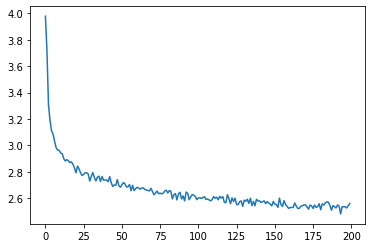

In [59]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

## 네트워크 샘플링

샘플링을 위행 네트워크에 하나의 글자를 주고 다음문자를 물어보고 다음문자를 전달하는것을 EOS 토큰까지 반복한다.

- 입력 카테고리, 시작문자, 은닉상태를 위한 비어있는 텐서를 생성 
- 시작 문자로 output_name 문자열 생성 
- 최대 출력 길이까지 현재문자를 네트워크에 전달, 확률값이 가장 높은 다음문자와 다음 은닉상태를 얻고 만일 문자가 EOS 면 멈춤. 만약 일반적인 문자라면 output_name에 추가하고 계속 실행
- 마지막 이름 반환
 


In [67]:
max_length = 20

# 카테고리와 시작 문자로 부터 샘플링 시작 
def sample(category, start_letter='A'):
    with torch.no_grad():
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()
        
        output_name = start_letter
        
        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters -1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)
            
        return output_name

# 하나의 카테고리와 여러시작 문자들로 여러개의 샘플 얻기 
def samples(category, start_letters="ABC"):
    for start_letter in start_letters:
        print(sample(category, start_letter))
        
samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')    

samples('Korean', 'KOR')    

Rosen
Uang
Sanger
Garin
Eang
Roun
Sangera
Pang
Arana
Caris
Hang
Iang
Kanger
Orana
Roun
